
# SHEFU — Regresión de presentación con EfficientNet‑Lite0 (PyTorch)

Este notebook rehace el modelo original de **regresión** (salida única en rango `[0,1]` con `Sigmoid`) usando **EfficientNet‑Lite0** como backbone, manteniendo el flujo completo:
- **Cargar CSV y dataset**
- **Aumentaciones + normalización (ImageNet)**
- **Entrenamiento** con validación, `EarlyStopping` y guardado del mejor modelo
- **Evaluación** (MAE/MSE)
- **Exportación a ONNX** (`.onnx`)
- **(Opcional)** conversión a **TFLite** vía `onnx2tf` → `.tflite` (con celdas preparadas)

> Requisitos base: Python 3.10+, PyTorch, torchvision, timm (para EfficientNet‑Lite0).


In [4]:

# (Si aún no lo tienes) instala timm para EfficientNet-Lite0
# Descomenta si lo necesitas:
#!pip install timm==1.0.9


In [5]:
import torch
print("CUDA disponible:", torch.cuda.is_available())
print("Versión de PyTorch:", torch.__version__)
print("Versión CUDA compilada:", torch.version.cuda)
print("GPU detectada:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No detectada")


CUDA disponible: True
Versión de PyTorch: 2.5.1+cu121
Versión CUDA compilada: 12.1
GPU detectada: NVIDIA GeForce RTX 2050


## ⚙️ Configuración

In [6]:

from pathlib import Path
import os, math, time, json, random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image

# Modelo
import timm  # EfficientNet-Lite0

# --------- Rutas (ajústalas a tu proyecto) ---------
# CSV con columnas: crop_path (ruta imagen), score_clean (0..100)
CSV_PATH = Path("dataset_regresion_extendido.csv")
CROP_DIR = Path("dataset/crops")
RUN_DIR = Path("runs/effnet_lite0_regresion")
RUN_DIR.mkdir(parents=True, exist_ok=True)

# Entrenamiento
IMG_SIZE = 240                   # EfficientNet-Lite0 usa 240x240
BATCH_SIZE = 32
EPOCHS = 30
LR = 1e-3
VAL_SPLIT = 0.2
SEED = 42
NUM_WORKERS = 2
PATIENCE = 7                     # EarlyStopping

# Exportación
ONNX_PATH = RUN_DIR / "model_regresion_effnet_lite0.onnx"
PT_BEST_PATH = RUN_DIR / "best_model.pth"

# Reproducibilidad
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


c:\Users\anays\OneDrive\Escritorio\SHEFU - ENTREGABLE VC\Completos\Detector completos\shefu_yolo2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [7]:
import pandas as pd
df = pd.read_csv(CSV_PATH)
print(df.columns.tolist())
df.head()


['core_name', 'split', 'img_path', 'annotation_id', 'annotator', 'comentario', 'created_at', 'data', 'id', 'lead_time', 'motivo', 'score', 'updated_at']


,core_name,split,img_path,annotation_id,annotator,comentario,created_at,data,id,lead_time,motivo,score,updated_at
0,112_jpg,train,../../Detector completos/Dataset-Comida-Chilen...,157.0,1.0,NaN,2025-09-12T05:45:37.979400Z,/data/upload/2/295053ca-112_jpg.rf.4b78c84562d...,154.0,11.435,NaN,"[{""number"":100}]",2025-09-12T05:45:37.979454Z
1,112_jpg,train,../../Detector completos/Dataset-Comida-Chilen...,157.0,1.0,NaN,2025-09-12T05:45:37.979400Z,/data/upload/2/295053ca-112_jpg.rf.4b78c84562d...,154.0,11.435,NaN,"[{""number"":100}]",2025-09-12T05:45:37.979454Z
2,112_jpg,train,../../Detector completos/Dataset-Comida-Chilen...,157.0,1.0,NaN,2025-09-12T05:45:37.979400Z,/data/upload/2/295053ca-112_jpg.rf.4b78c84562d...,154.0,11.435,NaN,"[{""number"":100}]",2025-09-12T05:45:37.979454Z
3,11_jpg,train,../../Detector completos/Dataset-Comida-Chilen...,127.0,1.0,NaN,2025-09-12T05:34:47.085387Z,/data/upload/2/0cc27140-11_jpg.rf.1d6a02483ef8...,124.0,10.655,"{""choices"":[""Falta de ingrediente"",""Buen balan...","[{""number"":80}]",2025-09-12T05:34:47.085458Z
4,11_jpg,train,../../Detector completos/Dataset-Comida-Chilen...,127.0,1.0,NaN,2025-09-12T05:34:47.085387Z,/data/upload/2/0cc27140-11_jpg.rf.1d6a02483ef8...,124.0,10.655,"{""choices"":[""Falta de ingrediente"",""Buen balan...","[{""number"":80}]",2025-09-12T05:34:47.085458Z


## 📦 Cargar datos y dividir train/val

In [8]:
import os, ast
from sklearn.model_selection import train_test_split

assert CSV_PATH.exists(), f"No se encontró el CSV en {CSV_PATH.resolve()}"

# -----------------------------------------------------------
# 1. Cargar CSV original (con rutas de imágenes sin recortar)
# -----------------------------------------------------------
df = pd.read_csv(CSV_PATH)

# -----------------------------------------------------------
# 2. Limpieza robusta del campo 'score'
# Algunos valores vienen como string tipo "[{'number': 82.0}]"
# Esta función los convierte correctamente a float.
# -----------------------------------------------------------
def clean_score_cell(x):
    try:
        if isinstance(x, str):
            data = ast.literal_eval(x)
            if isinstance(data, list) and data and isinstance(data[0], dict) and "number" in data[0]:
                return float(data[0]["number"])
            return float(x)
        return float(x)
    except Exception:
        return None

df["score_clean"] = df["score"].apply(clean_score_cell)

# Filtrar filas válidas
df = df.dropna(subset=["img_path", "score_clean"]).copy()

# -----------------------------------------------------------
# 3. Reconstruir el nombre del crop correspondiente
# Ejemplo: "../../Detector completos/.../train/images/112_jpg.rf.x.jpg"
# se convierte en: "dataset/crops/crop_train_112_jpg.rf.x.jpg"
# -----------------------------------------------------------
def build_crop_path(row):
    base = os.path.basename(str(row["img_path"]))  # ej. "112_jpg.rf.x.jpg"
    split = row.get("split", "train")               # usa "train" si falta
    crop_filename = f"crop_{split}_{base}"
    return str(Path("dataset/crops") / crop_filename)

df["crop_path"] = df.apply(build_crop_path, axis=1)

# Verificar existencia de archivos
missing = df.loc[~df["crop_path"].apply(os.path.exists)]
if len(missing) > 0:
    print(f"{len(missing)} crops no se encontraron físicamente en dataset/crops/")
else:
    print("Todos los crops existen correctamente en dataset/crops/")

# -----------------------------------------------------------
# 4. Normalización del score (0–100 → 0–1)
# -----------------------------------------------------------
df["score01"] = (df["score_clean"] / 100.0).clip(0.0, 1.0)

# -----------------------------------------------------------
# 5. Split estratificado para mantener la distribución de notas
# -----------------------------------------------------------
bins = np.clip((df["score01"] * 10).astype(int), 0, 9)
df["_bin"] = bins

# Usa los splits originales del CSV (sin mezclarlos)
train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df   = df[df["split"] == "valid"].reset_index(drop=True)
test_df  = df[df["split"] == "test"].reset_index(drop=True)

print(f"train: {len(train_df)} | valid: {len(val_df)} | test: {len(test_df)}")

print(f"train: {train_df.shape} | valid: {val_df.shape}")
train_df.head()


12 crops no se encontraron físicamente en dataset/crops/
train: 406 | valid: 40 | test: 20
train: (406, 17) | valid: (40, 17)


,core_name,split,img_path,annotation_id,annotator,comentario,created_at,data,id,lead_time,motivo,score,updated_at,score_clean,crop_path,score01,_bin
0,112_jpg,train,../../Detector completos/Dataset-Comida-Chilen...,157.0,1.0,NaN,2025-09-12T05:45:37.979400Z,/data/upload/2/295053ca-112_jpg.rf.4b78c84562d...,154.0,11.435,NaN,"[{""number"":100}]",2025-09-12T05:45:37.979454Z,100.0,dataset\crops\crop_train_112_jpg.rf.1f0aa54d9b...,1.0,9
1,112_jpg,train,../../Detector completos/Dataset-Comida-Chilen...,157.0,1.0,NaN,2025-09-12T05:45:37.979400Z,/data/upload/2/295053ca-112_jpg.rf.4b78c84562d...,154.0,11.435,NaN,"[{""number"":100}]",2025-09-12T05:45:37.979454Z,100.0,dataset\crops\crop_train_112_jpg.rf.3b0773602c...,1.0,9
2,112_jpg,train,../../Detector completos/Dataset-Comida-Chilen...,157.0,1.0,NaN,2025-09-12T05:45:37.979400Z,/data/upload/2/295053ca-112_jpg.rf.4b78c84562d...,154.0,11.435,NaN,"[{""number"":100}]",2025-09-12T05:45:37.979454Z,100.0,dataset\crops\crop_train_112_jpg.rf.4b78c84562...,1.0,9
3,11_jpg,train,../../Detector completos/Dataset-Comida-Chilen...,127.0,1.0,NaN,2025-09-12T05:34:47.085387Z,/data/upload/2/0cc27140-11_jpg.rf.1d6a02483ef8...,124.0,10.655,"{""choices"":[""Falta de ingrediente"",""Buen balan...","[{""number"":80}]",2025-09-12T05:34:47.085458Z,80.0,dataset\crops\crop_train_11_jpg.rf.1d6a02483ef...,0.8,8
4,11_jpg,train,../../Detector completos/Dataset-Comida-Chilen...,127.0,1.0,NaN,2025-09-12T05:34:47.085387Z,/data/upload/2/0cc27140-11_jpg.rf.1d6a02483ef8...,124.0,10.655,"{""choices"":[""Falta de ingrediente"",""Buen balan...","[{""number"":80}]",2025-09-12T05:34:47.085458Z,80.0,dataset\crops\crop_train_11_jpg.rf.bc216dc89f4...,0.8,8


## 🧪 Transforms (augment + normalización ImageNet)

In [9]:

# Mean/Std ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


## 🗂️ Dataset

In [10]:
class ScoreDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, tfms):
        """
        Dataset de regresión para evaluación visual.
        Usa rutas completas de los crops en 'crop_path' y scores normalizados en 'score01'.
        Si alguna imagen no existe, se salta automáticamente.
        """
        self.tfms = tfms

        # Filtramos desde el inicio las filas con archivos inexistentes
        frame = frame.copy()
        frame["exists"] = frame["crop_path"].apply(lambda p: Path(p).exists())
        missing = frame.loc[~frame["exists"], "crop_path"]

        if len(missing) > 0:
            print(f"⚠️ Se encontraron {len(missing)} imágenes inexistentes. Serán ignoradas.")
            # Si querés, podés guardar las rutas faltantes para revisar
            (Path("runs") / "missing_images.txt").write_text("\n".join(map(str, missing)))

        self.frame = frame[frame["exists"]].reset_index(drop=True)

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        row = self.frame.iloc[idx]
        img_path = Path(row["crop_path"])

        # Cargar imagen (ya debería existir, pero por seguridad...)
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"⚠️ Error al abrir {img_path}: {e}")
            # En caso de error, devolvemos una imagen negra y etiqueta 0.5
            img = Image.new("RGB", (240, 240), (0, 0, 0))
            y = torch.tensor([0.5], dtype=torch.float32)
            return self.tfms(img), y

        # Transformaciones y etiqueta normalizada
        x = self.tfms(img)
        y = torch.tensor([np.float32(row["score01"])], dtype=torch.float32)
        return x, y


## 🚚 DataLoaders

In [34]:
# Crear datasets usando las rutas completas (crop_path)
train_ds = ScoreDataset(train_df, train_tfms)
val_ds   = ScoreDataset(val_df, val_tfms)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,      # fuerza carga secuencial (sin procesos paralelos)
    pin_memory=False    # evita problemas en Windows + CPU
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,      # igual aquí
    pin_memory=False
)

len(train_loader), len(val_loader)
batch = next(iter(train_loader))
print(f"Ejemplo de batch: {batch[0].shape}")



⚠️ Se encontraron 10 imágenes inexistentes. Serán ignoradas.
⚠️ Se encontraron 1 imágenes inexistentes. Serán ignoradas.
Ejemplo de batch: torch.Size([32, 3, 240, 240])


## 🧠 Modelo: EfficientNet‑Lite0 + cabeza de regresión (Sigmoid)

In [35]:
from timm import create_model
import torch.nn as nn

model = create_model("efficientnet_lite0", pretrained=True)
in_f = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(in_f, 1),
    nn.Sigmoid()
)
model = model.to(device)
print(f"Parámetros totales: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")


Parámetros totales: 3.37M


## 🏋️ Entrenamiento

In [36]:
from collections import defaultdict
from tqdm import tqdm  # opcional: barra de progreso elegante
EPOCHS = 100
PATIENCE = 10
criterion = nn.MSELoss()  # Pérdida MSE para score continuo [0,1]
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

def mae(y_pred, y_true):
    """Mean Absolute Error (en rango 0–1)."""
    return torch.mean(torch.abs(y_pred - y_true))

best_val = float("inf")
best_state = None
history = defaultdict(list)
no_improve = 0

print("Iniciando entrenamiento...\n")
# Congelar backbone antes del loop
for param in model.blocks.parameters():
    param.requires_grad = False
print("Backbone EfficientNet-Lite0 congelado (solo se entrenará la cabeza).")

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    print(f"\nEpoch {epoch}/{EPOCHS} — LR: {optimizer.param_groups[0]['lr']:.6f}")
    # Congelar backbone por las primeras 5 épocas
    if epoch == 6:
        print("Descongelando EfficientNet-Lite0 para fine-tuning fino...")
        for param in model.blocks.parameters():
            param.requires_grad = True

    # ---- Entrenamiento ----
    model.train()
    tr_loss, tr_mae = 0.0, 0.0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item() * x.size(0)
        tr_mae  += mae(pred, y).item() * x.size(0)

    tr_loss /= len(train_ds)
    tr_mae  /= len(train_ds)

    # ---- Validación ----
    model.eval()
    vl_loss, vl_mae = 0.0, 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            vl_loss += loss.item() * x.size(0)
            vl_mae  += mae(pred, y).item() * x.size(0)

    vl_loss /= len(val_ds)
    vl_mae  /= len(val_ds)

    scheduler.step(vl_loss)

    # Guardar métricas
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(vl_loss)
    history["train_mae"].append(tr_mae)
    history["val_mae"].append(vl_mae)

    # ---- EarlyStopping basado en val_loss ----
    monitor = vl_loss
    improved = monitor < best_val - 1e-6
    if improved:
        best_val = monitor
        best_state = model.state_dict()
        torch.save(best_state, str(PT_BEST_PATH))
        no_improve = 0
    else:
        no_improve += 1

    dur = time.time() - t0
    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"train_loss={tr_loss:.4f} val_loss={vl_loss:.4f} "
        f"| train_MAE={tr_mae*100:.2f} val_MAE={vl_mae*100:.2f} "
        f"| best_val_loss={best_val:.4f} | {dur:.1f}s"
    )

    if no_improve >= PATIENCE:
        print(f"EarlyStopping activado: {PATIENCE} epochs sin mejora en val_loss.")
        break

# ---- Restaurar mejor modelo ----
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\nMejor modelo cargado desde: {PT_BEST_PATH}")
else:
    print("\nNo se guardó ningún mejor modelo (posible falta de mejora en val_loss).")

# ---- Guardar historial de métricas ----
import json
history_path = RUN_DIR / "training_history.json"
with open(history_path, "w") as f:
    json.dump(history, f)
print(f"Historial de entrenamiento guardado en: {history_path}")


Iniciando entrenamiento...

Backbone EfficientNet-Lite0 congelado (solo se entrenará la cabeza).

Epoch 1/100 — LR: 0.001000


Epoch 1/100:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 01/100 | train_loss=0.0553 val_loss=0.0564 | train_MAE=17.69 val_MAE=16.76 | best_val_loss=0.0564 | 7.0s

Epoch 2/100 — LR: 0.001000


Epoch 02/100 | train_loss=0.0285 val_loss=0.0541 | train_MAE=13.17 val_MAE=16.38 | best_val_loss=0.0541 | 6.8s

Epoch 3/100 — LR: 0.001000


Epoch 03/100 | train_loss=0.0218 val_loss=0.0608 | train_MAE=11.16 val_MAE=17.30 | best_val_loss=0.0541 | 6.5s

Epoch 4/100 — LR: 0.001000


Epoch 04/100 | train_loss=0.0190 val_loss=0.0718 | train_MAE=10.37 val_MAE=19.10 | best_val_loss=0.0541 | 7.2s

Epoch 5/100 — LR: 0.001000


Epoch 05/100 | train_loss=0.0158 val_loss=0.0620 | train_MAE=9.71 val_MAE=16.93 | best_val_loss=0.0541 | 7.2s

Epoch 6/100 — LR: 0.001000
Descongelando EfficientNet-Lite0 para fine-tuning fino...


Epoch 06/100 | train_loss=0.0267 val_loss=0.0711 | train_MAE=12.37 val_MAE=18.96 | best_val_loss=0.0541 | 7.7s

Epoch 7/100 — LR: 0.000500


Epoch 07/100 | train_loss=0.0133 val_loss=0.0687 | train_MAE=9.07 val_MAE=18.11 | best_val_loss=0.0541 | 7.5s

Epoch 8/100 — LR: 0.000500


Epoch 08/100 | train_loss=0.0089 val_loss=0.0651 | train_MAE=7.26 val_MAE=17.18 | best_val_loss=0.0541 | 7.6s

Epoch 9/100 — LR: 0.000500


Epoch 09/100 | train_loss=0.0063 val_loss=0.0539 | train_MAE=6.13 val_MAE=16.13 | best_val_loss=0.0539 | 7.7s

Epoch 10/100 — LR: 0.000500


Epoch 10/100 | train_loss=0.0046 val_loss=0.0524 | train_MAE=5.28 val_MAE=15.88 | best_val_loss=0.0524 | 7.8s

Epoch 11/100 — LR: 0.000500


Epoch 11/100 | train_loss=0.0052 val_loss=0.0570 | train_MAE=5.55 val_MAE=16.68 | best_val_loss=0.0524 | 7.5s

Epoch 12/100 — LR: 0.000500


Epoch 12/100 | train_loss=0.0032 val_loss=0.0549 | train_MAE=4.42 val_MAE=16.31 | best_val_loss=0.0524 | 8.0s

Epoch 13/100 — LR: 0.000500


Epoch 13/100 | train_loss=0.0033 val_loss=0.0512 | train_MAE=4.48 val_MAE=15.72 | best_val_loss=0.0512 | 8.6s

Epoch 14/100 — LR: 0.000500


Epoch 14/100 | train_loss=0.0033 val_loss=0.0483 | train_MAE=4.63 val_MAE=15.66 | best_val_loss=0.0483 | 9.1s

Epoch 15/100 — LR: 0.000500


Epoch 15/100 | train_loss=0.0031 val_loss=0.0500 | train_MAE=4.23 val_MAE=15.78 | best_val_loss=0.0483 | 8.6s

Epoch 16/100 — LR: 0.000500


Epoch 16/100 | train_loss=0.0029 val_loss=0.0527 | train_MAE=4.34 val_MAE=16.31 | best_val_loss=0.0483 | 8.9s

Epoch 17/100 — LR: 0.000500


Epoch 17/100 | train_loss=0.0033 val_loss=0.0542 | train_MAE=4.48 val_MAE=16.52 | best_val_loss=0.0483 | 9.1s

Epoch 18/100 — LR: 0.000500


Epoch 18/100 | train_loss=0.0025 val_loss=0.0480 | train_MAE=3.92 val_MAE=15.85 | best_val_loss=0.0480 | 8.9s

Epoch 19/100 — LR: 0.000500


Epoch 19/100 | train_loss=0.0025 val_loss=0.0544 | train_MAE=3.89 val_MAE=16.65 | best_val_loss=0.0480 | 8.5s

Epoch 20/100 — LR: 0.000500


Epoch 20/100 | train_loss=0.0037 val_loss=0.0566 | train_MAE=4.67 val_MAE=16.79 | best_val_loss=0.0480 | 8.7s

Epoch 21/100 — LR: 0.000500


Epoch 21/100 | train_loss=0.0027 val_loss=0.0547 | train_MAE=4.05 val_MAE=16.74 | best_val_loss=0.0480 | 8.9s

Epoch 22/100 — LR: 0.000500


Epoch 22/100 | train_loss=0.0030 val_loss=0.0610 | train_MAE=3.98 val_MAE=17.49 | best_val_loss=0.0480 | 8.9s

Epoch 23/100 — LR: 0.000250


Epoch 23/100 | train_loss=0.0039 val_loss=0.0544 | train_MAE=4.71 val_MAE=16.69 | best_val_loss=0.0480 | 8.5s

Epoch 24/100 — LR: 0.000250


Epoch 24/100 | train_loss=0.0032 val_loss=0.0550 | train_MAE=4.57 val_MAE=17.05 | best_val_loss=0.0480 | 9.0s

Epoch 25/100 — LR: 0.000250


Epoch 25/100 | train_loss=0.0023 val_loss=0.0548 | train_MAE=3.63 val_MAE=16.72 | best_val_loss=0.0480 | 8.9s

Epoch 26/100 — LR: 0.000250


Epoch 26/100 | train_loss=0.0019 val_loss=0.0542 | train_MAE=3.40 val_MAE=16.70 | best_val_loss=0.0480 | 8.4s

Epoch 27/100 — LR: 0.000125


Epoch 27/100 | train_loss=0.0013 val_loss=0.0567 | train_MAE=2.89 val_MAE=17.03 | best_val_loss=0.0480 | 8.7s

Epoch 28/100 — LR: 0.000125


Epoch 28/100 | train_loss=0.0014 val_loss=0.0559 | train_MAE=2.92 val_MAE=16.87 | best_val_loss=0.0480 | 8.4s
EarlyStopping activado: 10 epochs sin mejora en val_loss.

Mejor modelo cargado desde: runs\effnet_lite0_regresion\best_model.pth
Historial de entrenamiento guardado en: runs\effnet_lite0_regresion\training_history.json


## 📈 Curvas de entrenamiento

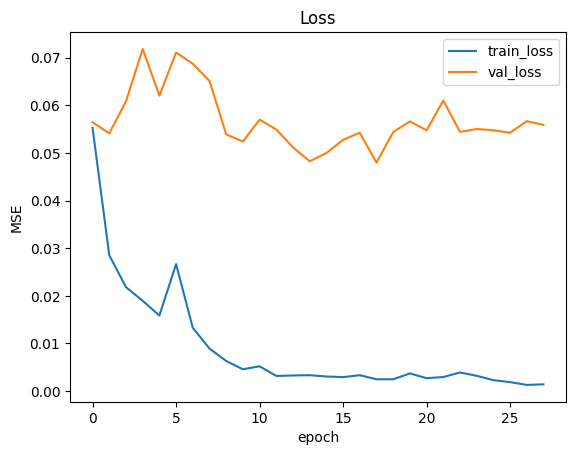

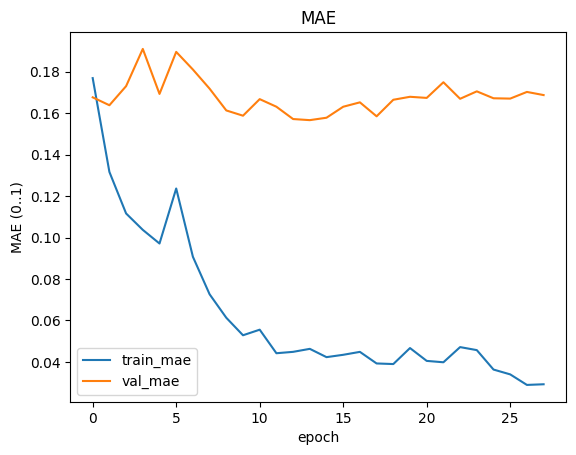

In [37]:

import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.show()

plt.figure()
plt.plot(history["train_mae"], label="train_mae")
plt.plot(history["val_mae"], label="val_mae")
plt.legend(); plt.title("MAE"); plt.xlabel("epoch"); plt.ylabel("MAE (0..1)"); plt.show()


## 🔍 Evaluación rápida (pred vs. etiqueta)

In [38]:

model.eval()
xs, ys, ps = [], [], []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        p = model(x).cpu().numpy().ravel()
        ys.extend(y.numpy().ravel().tolist())
        ps.extend(p.tolist())

mae_val = np.mean(np.abs(np.array(ps) - np.array(ys)))
mse_val = np.mean((np.array(ps) - np.array(ys))**2)
print(f"VAL MAE: {mae_val:.4f} | VAL MSE: {mse_val:.4f}")


VAL MAE: 0.1687 | VAL MSE: 0.0559


⚠️ Se encontraron 1 imágenes inexistentes. Serán ignoradas.
✅ Resultados guardados en runs\effnet_lite0_regresion\test_results_final.csv (19 filas)
📊 MAE: 17.01 | RMSE: 20.43 (escala 0–100)


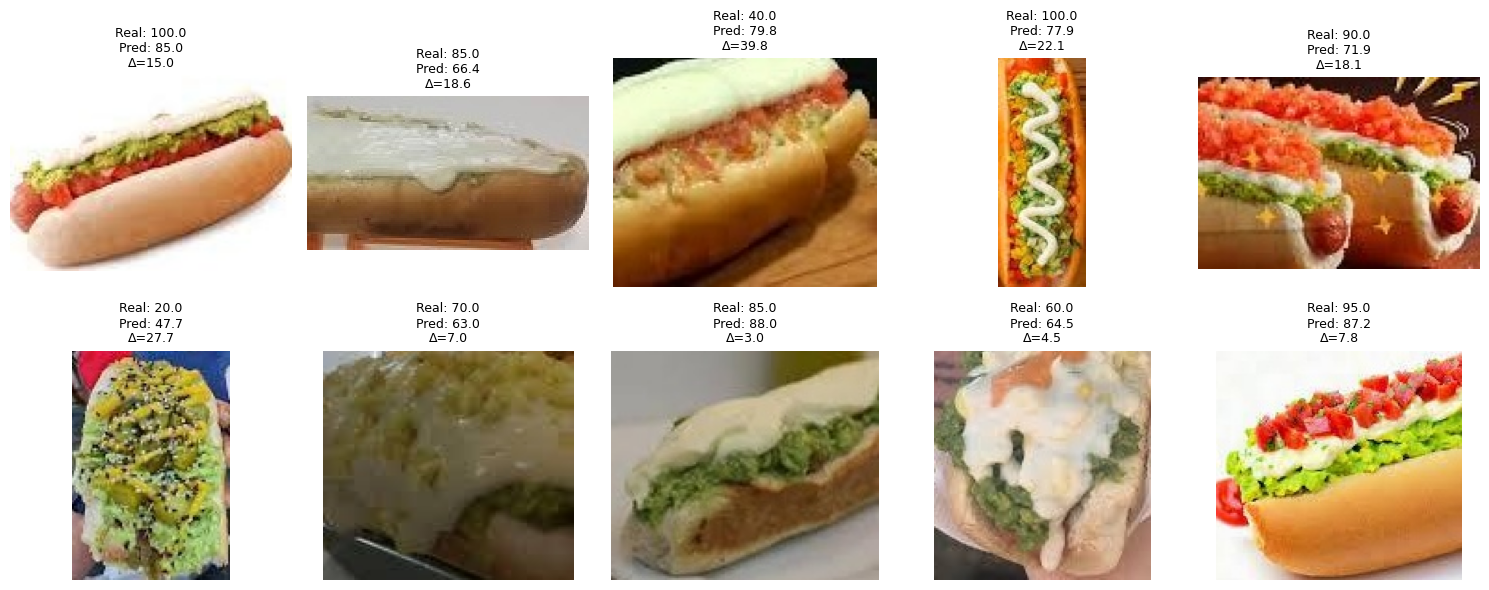

In [44]:
# =========================================================
# 5) EVALUACIÓN + VISUALIZACIÓN EN TEST SET (EfficientNet-Lite0)
# =========================================================
import math, os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# 🔹 Asegúrate de tener esto antes:
# test_df  = df[df["split"] == "test"].reset_index(drop=True)
test_ds  = ScoreDataset(test_df, val_tfms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model.eval()
results = []

loader = test_loader
df_eval = test_df.copy()

# 🔹 Evaluación con tracking de archivos
with torch.no_grad():
    for i, (imgs, scores) in enumerate(loader):
        imgs = imgs.to(device)
        preds = model(imgs).cpu().numpy().flatten() * 100
        reals = scores.numpy().flatten() * 100
        batch_size = len(preds)

        # Subconjunto correspondiente dentro del DataFrame de test
        start_idx = i * loader.batch_size
        end_idx = start_idx + batch_size
        sub_df = df_eval.iloc[start_idx:end_idx]

        for j, row in enumerate(sub_df.itertuples()):
            results.append({
                "img_path": row.crop_path,
                "real": float(reals[j]),
                "pred": float(preds[j]),
                "core_name": getattr(row, "core_name", "NA")
            })

# 🔹 Convertir resultados a DataFrame
results_df = pd.DataFrame(results)
results_df["error_abs"] = abs(results_df["real"] - results_df["pred"])

# Guardar CSV con resultados
out_csv = Path("runs/effnet_lite0_regresion/test_results_final.csv")
out_csv.parent.mkdir(parents=True, exist_ok=True)
results_df.to_csv(out_csv, index=False)
print(f"✅ Resultados guardados en {out_csv} ({len(results_df)} filas)")

# 🔹 Métricas globales (escala 0–100)
mae  = results_df["error_abs"].mean()
rmse = math.sqrt(((results_df["real"] - results_df["pred"]) ** 2).mean())
print(f"📊 MAE: {mae:.2f} | RMSE: {rmse:.2f} (escala 0–100)")

# =========================================================
# 6) VISUALIZACIÓN: predicciones vs reales (aleatorias)
# =========================================================
n = 10
cols = 5
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
axes = axes.flatten()

subset = results_df.sample(n=n, random_state=None)

for i, row in enumerate(subset.itertuples()):
    try:
        img = Image.open(row.img_path)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(
            f"Real: {row.real:.1f}\nPred: {row.pred:.1f}\nΔ={row.error_abs:.1f}",
            fontsize=9
        )
    except Exception as e:
        axes[i].axis("off")
        axes[i].set_title(f"⚠️ Error\n{os.path.basename(row.img_path)}", fontsize=7)

# Apagar los ejes vacíos
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


## 🧾 Exportación a ONNX

In [45]:

model.eval()
dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=device)
torch.onnx.export(
    model, dummy, str(ONNX_PATH),
    input_names=["input"], output_names=["score01"],
    dynamic_axes={"input": {0: "batch"}, "score01": {0: "batch"}},
    opset_version=17
)
print(f"ONNX exportado en: {ONNX_PATH.resolve()}")


ONNX exportado en: C:\Users\anays\OneDrive\Escritorio\SHEFU - ENTREGABLE VC\Completos\completos_regresion\v1 - Regresión simple\runs\effnet_lite0_regresion\model_regresion_effnet_lite0.onnx


### (Opcional) Chequeo rápido con onnxruntime

In [ ]:

# Descomenta si quieres validar el ONNX localmente
# %pip install onnxruntime
# import onnxruntime as ort
# import numpy as np

# ort_sess = ort.InferenceSession(str(ONNX_PATH), providers=['CPUExecutionProvider'])
# x = np.random.randn(1,3,IMG_SIZE,IMG_SIZE).astype(np.float32)
# out = ort_sess.run(None, {"input": x})
# print("Salida ONNX (shape):", out[0].shape, " ejemplo:", out[0][0,0])



## 📦 (Opcional) Conversión a **TFLite** desde ONNX

Ruta recomendada (probada en Windows):  
**PyTorch → ONNX → onnx2tf → SavedModel → TFLite**

> Nota: estas celdas instalan dependencias específicas. Ejecútalas en un **entorno limpio** si tienes conflictos previos.


In [ ]:

# 1) Instalar dependencias compatibles (usa un venv/conda limpio si es posible)
# %pip uninstall -y tensorflow tensorflow-intel tf-keras onnx onnx2tf protobuf ml-dtypes tensorboard ai-edge-litert
# %pip install tensorflow==2.16.1 tf-keras==2.16.0 onnx==1.16.1 onnx2tf==1.17.3 protobuf==4.25.3


In [1]:

# 2) Convertir ONNX -> TensorFlow SavedModel (carpeta ./tf_model)
# Este paso crea un SavedModel en ./tf_model que luego puedes convertir a .tflite
from onnx2tf import convert
convert(
    onnx_model_path=str(ONNX_PATH),
    output_folder_path="tf_model",
    copy_onnx_input_output_names_to_tflite=True,
    non_verbose=True
 )
print("SavedModel exportado a ./tf_model")


ModuleNotFoundError: No module named 'onnx2tf'

✅ Modelo TFLite cargado correctamente.
Input shape: [  1   3 240 240]
Output shape: [1 1]
⚠️ Se encontraron 1 imágenes inexistentes. Serán ignoradas.
✅ Resultados guardados en runs\effnet_lite0_regresion\test_results_tflite.csv (19 filas)
📊 MAE: 17.01 | RMSE: 20.42 (escala 0–100)


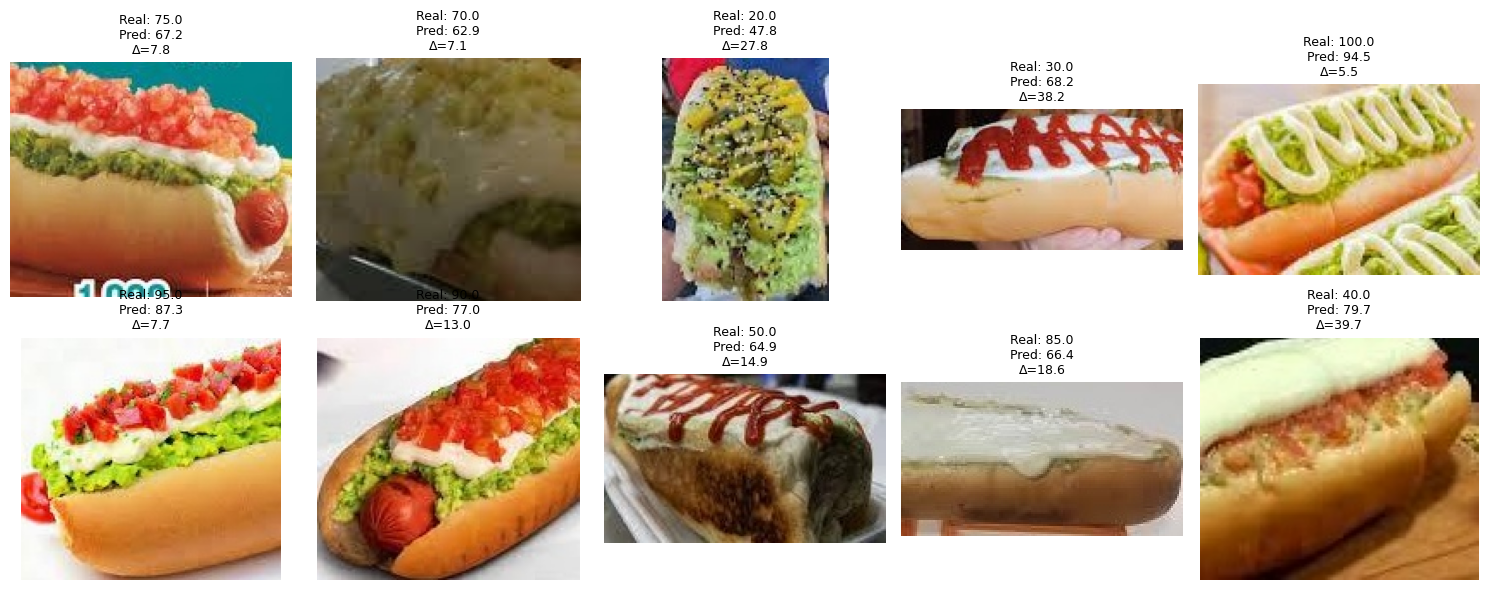

In [13]:
# =========================================================
# 5) EVALUACIÓN CON TFLITE (EfficientNet-Lite0)
# =========================================================
import tensorflow as tf
import numpy as np
import pandas as pd
import math, os
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# --- Cargar el modelo TFLite --- ""
TFLITE_PATH = r"runs\efficientnet_lite0.tflite"
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("✅ Modelo TFLite cargado correctamente.")
print("Input shape:", input_details[0]["shape"])
print("Output shape:", output_details[0]["shape"])

# --- Dataset de test (ya normalizado como durante el entrenamiento) ---
test_ds  = ScoreDataset(test_df, val_tfms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)

results = []

# --- Evaluación ---
for i, (img, score) in enumerate(test_loader):
    img_np = img.numpy().astype(np.float32)  # Mantener NCHW
    score_np = score.numpy().flatten() * 100.0  # nota real en 0–100

    interpreter.set_tensor(input_details[0]['index'], img_np)
    interpreter.invoke()
    pred = interpreter.get_tensor(output_details[0]['index']).flatten() * 100.0

    row = test_df.iloc[i]
    results.append({
        "img_path": row["crop_path"],
        "real": float(score_np[0]),
        "pred": float(pred[0]),
        "core_name": row.get("core_name", "NA")
    })

# --- Resultados ---
results_df = pd.DataFrame(results)
results_df["error_abs"] = abs(results_df["real"] - results_df["pred"])

out_csv = Path("runs/effnet_lite0_regresion/test_results_tflite.csv")
out_csv.parent.mkdir(parents=True, exist_ok=True)
results_df.to_csv(out_csv, index=False)
print(f"✅ Resultados guardados en {out_csv} ({len(results_df)} filas)")

# --- Métricas globales ---
mae  = results_df["error_abs"].mean()
rmse = math.sqrt(((results_df["real"] - results_df["pred"]) ** 2).mean())
print(f"📊 MAE: {mae:.2f} | RMSE: {rmse:.2f} (escala 0–100)")

# =========================================================
# 6) VISUALIZACIÓN DE PREDICCIONES
# =========================================================
n = 10
cols = 5
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
axes = axes.flatten()

subset = results_df.sample(n=n, random_state=None)
for i, row in enumerate(subset.itertuples()):
    try:
        img = Image.open(row.img_path)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Real: {row.real:.1f}\nPred: {row.pred:.1f}\nΔ={row.error_abs:.1f}", fontsize=9)
    except Exception:
        axes[i].axis("off")
        axes[i].set_title("⚠️ Error", fontsize=8)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [ ]:

# 3) Convertir SavedModel -> TFLite
# import tensorflow as tf
# converter = tf.lite.TFLiteConverter.from_saved_model("tf_model")
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# # Para cuantización completa de enteros necesitarías un representant dataset (no incluído aquí).
# tflite_model = converter.convert()
# with open(str(RUN_DIR / "model_regresion_effnet_lite0.tflite"), "wb") as f:
#     f.write(tflite_model)
# print("TFLite guardado en:", (RUN_DIR / "model_regresion_effnet_lite0.tflite").resolve())



---

### 📱 Notas de integración (Flutter)

- **Entrada**: tensor `float32[1, 3, 240, 240]` normalizado con mean/std de ImageNet.  
- **Salida**: `float32[1,1]` con score en rango `[0,1]`. Multiplica por 100 en la app si necesitas escala 0–100.
- Plugins sugeridos: `tflite_flutter` para `.tflite`, o `onnxruntime` para `.onnx` (vía FFI).  
- Asegúrate de reproducir en Dart la **misma normalización** (mean/std) y el **resize 240x240**.

¡Listo! Con esto deberías poder re‑entrenar y exportar el modelo con EfficientNet‑Lite0.
